In [1]:
import numpy as np
import math
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.special import expit
import matplotlib.pyplot as plt
from random import randint


In [150]:
# Load and configure data
wine_data = load_wine()
# The data matrix (178,)
data = np.asarray(wine_data.data)
# The classification matrix (178,13)
target = np.asarray(wine_data.target)

# choose the first 130 to make it a binary problem
# Since the original data is organized -> simply choose first 130 elem)
X = data[0:130]
Y = target[0:130]
# preprocessing fix to avoid convergencewarning
X = StandardScaler().fit_transform(X)
# Append b to the list
X = np.asarray(np.hstack((X, np.ones((len(X),1)))))
# modify Y to use -1 and 1 labels
# Y = np.where(Y == 0, -1, Y)

## Standard logistic regression solver

In [129]:


# Standard logistic regression https://stackoverflow.com/questions/25427650/sklearn-logisticregression-without-regularization
# penalty = 'none' means no regularlation
lr = LogisticRegression(random_state=1, C=math.pow(10, 5),max_iter=10000, solver='sag')
lr.fit(X,Y)
w = lr.coef_ 
print("w:", w)
# L_star = loss_s(X, Y, w)
#print("L* = ", L_star)
L_star = log_loss(Y, lr.predict_proba(X))
print("L* = ", L_star)

w: [[-5.65567085 -2.04749007 -4.36012073  5.49155832 -0.72937152  0.08800773
  -1.54767875  0.65781456  0.64179689 -2.00784809  0.46035315 -2.46101695
  -7.43793772  0.01431959]]
L* =  0.00022533393014774908


## Coordinate Descent 

In [151]:
# helper functions
from sklearn.metrics import accuracy_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# cross entropy loss
def ce_loss(y,y_pred):
    #a = -(1/len(y))*np.sum(y*np.log(y_pred) + (1 - y)*np.log(1 - y_pred))
    a = -(1/len(y))
    b = y*np.log(y_pred)
    c = (1-y)*np.log(1-y_pred)
    d = a*np.sum(b+c)
    return d

# corss entropy gradient
def ce_grad(y,y_pred, X):
    return list(np.dot((y_pred - y),X)[0])

# logistice regression loss
def loss_s(X, y, w):
    loss = 0;
    for i in range(len(X)):
        dot = np.dot(w.T, X[i]);
        assert dot.shape[0] ==1
        loss += np.log(1 + np.exp(-y[i]* dot))
    return loss
    
# logistice regression gradient
def loss_prime(X,Y,w):
    grad = 0;
    for i in range(len(X)):
        #print("x:",X[i], "\ny:", Y[i], "\nw:",w)
        denominator = 1 + np.exp(Y[i] * np.dot(w.T, X[i].reshape(14,1)))
        #print(np.exp(Y[i]*np.dot(w, X[i])))
        loss_i = (-Y[i]*X[i])/(denominator)
        grad += loss_i
    return grad[0];

In [177]:
eta = 0.01
def coordinate_descent(isRandom):
    w = np.zeros(14).reshape(14,1)
    w += np.random.normal(0, 0.01, (14,1))
    loss = []
    # a value between 0 and 1
    for i in range(100000):
         # predict step 
        y_pred = sigmoid(np.dot(w.T,X.T))
        gradient = ce_grad(Y,y_pred,X)
    
        index = randint(0,13) if isRandom else np.argmax(np.abs(gradient)) # idx with largest magnitude       
        # update that coordinate with largest gradient in magnitude
        gradient_j = np.asarray([gradient[index] if j == index else 0 for j in range(0,14)])
        w_new = w - eta * gradient_j.reshape(14,1)
        # calculate loss and assing w_new
        curr_loss = ce_loss(Y,y_pred)
        # prev_loss = loss_s(X, Y, w)
        # print(curr_loss, prev_loss)
        loss.append(curr_loss)
        w = w_new       
    return (loss, w)

#def coordinate_descent_log(isRandom):


In [178]:
def print_result(loss, w):
    predict = sigmoid(np.dot(w.T, X.T))
    predict = np.where(predict>=0.5, 1, 0).flatten()
    # print(predict)
    # print(Y)
    print("Accuracy for coordinate descent: ",accuracy_score(Y, predict))
    print("Loss L = {0}".format(loss[-1]))
    #print(loss_custom, w_custom)

loss_custom, w_custom = coordinate_descent(False)
loss_rand, w_rand = coordinate_descent(True)
print_result(loss_custom, w_custom)
print_result(loss_rand, w_rand)

Accuracy for coordinate descent:  1.0
Loss L = 0.00019293057615819438
Accuracy for coordinate descent:  1.0
Loss L = 0.00042198861348577107


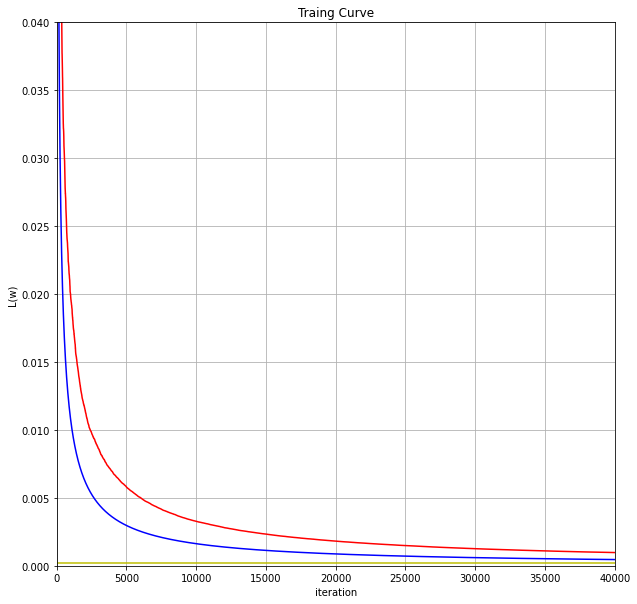

In [187]:
#Plot
plt.figure(figsize=(10,10))
plt.plot(loss_custom, 'b', label='Best Coordinate Descent') # loss best coordinate descent
plt.plot(loss_rand, 'r', label='Random Coordinate Descent')
plt.axhline(y=L_star, color='y', label='L*')
plt.title('Traing Curve')
plt.xlabel('iteration')
plt.ylabel('L(w)')
plt.xlim(0,40000)
plt.ylim((0,0.04))
plt.grid()
plt.show()